In [1]:
import os
import numpy as np
import pandas as pd
import pymc3 as pm
import tensorflow as tf
import theano.tensor as T
import matplotlib.pyplot as plt
import jax.numpy as jnp

from tensorflow.keras.models import load_model
from pymc3 import sampling_jax
from jax import nn, jit

import arviz as az
print('tensorflow ==', tf.__version__)

%matplotlib inline

tensorflow == 2.3.2


/home/ADF/ajl573/.virtualenvs/tensorflow/lib/python3.6/site-packages/pymc3/sampling_jax.py:22: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Emulator

In [2]:
path = 'data/models/test_model_2'
model = load_model(path)

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1

In [4]:
weights = model.get_weights()

In [5]:
input_offset = model.layers[0].mean.numpy()
input_scale = np.sqrt(model.layers[0].variance.numpy())

In [6]:
output_offset = np.array(model.layers[-1].offset)
output_scale = np.array(model.layers[-1].scale)

In [7]:
w = weights[3:-1:2]  # hidden layer weights
b = weights[4::2]    # hidden layer biases    

In [8]:
def emulate(inputs):
    inputs = (input_offset - inputs) / input_scale
    for wi, bi in zip(w[:-1], b[-1]):
        inputs = T.nnet.elu(T.dot(inputs, wi) + bi)  # x_(n+1) = activation( W . x_(n) + b )
    outputs = T.dot(inputs, w[-1]) + b[-1]
    outputs = output_offset + outputs * output_scale
    return outputs

## Data

In [9]:
bulk = pd.read_csv('data/inputs/bulk_inputs.csv')
bulk.head()

,KIC,R,err_R,M,err_M,Age,err_Age,alpha,err_alpha,Teff,err_Teff,[M/H],err_[M/H],L,err_L
0,3427720,1.113,0.007,1.102,0.017,2.296,0.151,1.69,0.07,6045,77,-0.06,0.1,1.590,0.066
1,3656476,1.327,0.013,1.105,0.030,8.741,0.527,1.75,0.07,5668,77,0.25,0.1,1.779,0.077
2,3735871,1.107,0.009,1.132,0.024,1.836,0.231,1.73,0.09,6107,77,-0.04,0.1,1.638,0.073
3,4914923,1.383,0.010,1.134,0.022,6.410,0.437,1.66,0.06,5805,77,0.08,0.1,2.138,0.098
4,5184732,1.369,0.009,1.282,0.024,4.832,0.308,1.65,0.08,5846,77,0.36,0.1,1.947,0.061


In [10]:
hall = pd.read_csv('data/hall2021/table1.csv', index_col=0)
hall.head()

,KIC,Teff,eTeff,age,loage,upage,modmass,lomodmass,upmodmass,feh,...,u_nus*,i,l_i,u_i,P,l_P,u_P,flag,hrclass,source
0,1435467,6326,77,3.0164,0.3513,0.4951,1.3189,0.0513,0.0304,0.01,...,0.097947,63.426473,6.630832,10.191850,6.541180,0.620728,0.757775,0,H,L
1,2837475,6614,77,1.6270,0.1757,0.1118,1.4291,0.0209,0.0190,0.01,...,0.075408,70.745188,4.373721,6.031740,3.499114,0.154079,0.172064,0,H,L
2,3425851,6343,85,3.3200,0.6400,0.8500,1.1780,0.0490,0.0490,-0.04,...,0.478841,60.891571,22.743612,20.057892,8.082749,2.709672,8.637542,0,H,K
3,3427720,6045,77,2.2339,0.2396,0.2396,1.1080,0.0095,0.0209,-0.06,...,0.056955,56.407964,23.391922,22.854263,31.590512,11.821919,10.236450,0,MS,L
4,3456181,6384,77,2.0901,0.1278,0.1278,1.4975,0.0190,0.0304,-0.15,...,0.079464,58.206608,17.723228,20.416392,10.699926,2.790842,2.006340,0,H,L


In [11]:
hall['KIC'] = hall['KIC'].astype(str)

In [12]:
period_cols = ['KIC', 'P', 'l_P', 'u_P', 'flag', 'hrclass']

hall[period_cols].head()

,KIC,P,l_P,u_P,flag,hrclass
0,1435467,6.541180,0.620728,0.757775,0,H
1,2837475,3.499114,0.154079,0.172064,0,H
2,3425851,8.082749,2.709672,8.637542,0,H
3,3427720,31.590512,11.821919,10.236450,0,MS
4,3456181,10.699926,2.790842,2.006340,0,H


In [13]:
df = bulk.merge(hall[period_cols], on='KIC')

In [35]:
data = df.loc[(df['M'] + 1.5*df['err_M'] < 1.2) & (df['alpha'] + 1.5*df['err_alpha'] < 2.0)].copy()
data.head()

,KIC,R,err_R,M,err_M,Age,err_Age,alpha,err_alpha,Teff,err_Teff,[M/H],err_[M/H],L,err_L,P,l_P,u_P,flag,hrclass
0,3427720,1.113,0.007,1.102,0.017,2.296,0.151,1.69,0.07,6045,77,-0.06,0.1,1.590,0.066,31.590512,11.821919,10.236450,0,MS
1,3656476,1.327,0.013,1.105,0.030,8.741,0.527,1.75,0.07,5668,77,0.25,0.1,1.779,0.077,48.040844,12.682362,8.116435,0,MS
2,3735871,1.107,0.009,1.132,0.024,1.836,0.231,1.73,0.09,6107,77,-0.04,0.1,1.638,0.073,15.810470,2.465683,1.821666,0,MS
3,4914923,1.383,0.010,1.134,0.022,6.410,0.437,1.66,0.06,5805,77,0.08,0.1,2.138,0.098,21.393839,3.536735,5.394345,0,MS
5,6116048,1.240,0.009,1.062,0.020,5.753,0.338,1.70,0.09,6033,77,-0.23,0.1,1.997,0.072,17.901072,1.185210,0.849631,0,MS


In [36]:
n_stars = len(data)
print(n_stars)

17


In [37]:
data['err_P'] = (data['l_P'] + data['u_P']) / 2

## Model

In [46]:
with pm.Model() as model:
    # hyperparameters
    fk = pm.Bound(pm.Normal, 5.0, 10.0)('fk', 7.5, 1.0)
    rocrit = pm.Bound(pm.Normal, 1.0, 4.5)('rocrit', 2.2, 1.0)
    
    # parameters
    age = pm.Normal('age', data['Age'], 2*data['err_Age'], shape=n_stars)
    mass = pm.Bound(pm.Normal, 0.8, 1.2)('mass', data['M'], 2*data['err_M'], shape=n_stars)
    feh = pm.Uniform('feh', -0.3, 0.3, shape=n_stars)
    mlt = pm.Bound(pm.Normal, 1.4, 2.0)('mlt', data['alpha'], 2*data['err_alpha'], shape=n_stars)
    
    inputs = T.stack([T.log10(age), mass, feh, mlt, fk*T.ones(n_stars), rocrit*T.ones(n_stars)]).T
    outputs = emulate(inputs)
    
    teff = pm.Deterministic('teff', 10**outputs[:, 0])
    radius = pm.Deterministic('radius', 10**outputs[:, 1])
    fehs = pm.Deterministic('fehs', outputs[:, 2])
    prot = pm.Deterministic('prot', 10**outputs[:, 3])
    
    obs_prot = pm.Normal('obs_prot', prot, data['err_P'], observed=data['P'])

In [ ]:
with model:
#     trace = sampling_jax.sample_numpyro_nuts(progress_bar=False)
    trace = pm.sample(init='map', tune=1000, target_accept=0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using map...
INFO:pymc3:Initializing NUTS using map...


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mlt, feh, mass, age, rocrit, fk]
INFO:pymc3:NUTS: [mlt, feh, mass, age, rocrit, fk]


In [ ]:
with model:
    az.plot_trace(trace)

In [25]:
trace

Inference data with groups:
	> posterior

(array([ 1.,  1.,  0.,  0., 11., 10.,  5.,  1.,  2.,  1.]),
 array([1.17 , 1.281, 1.392, 1.503, 1.614, 1.725, 1.836, 1.947, 2.058,
        2.169, 2.28 ]),
 <BarContainer object of 10 artists>)

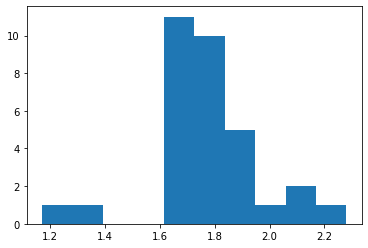

In [24]:
plt.hist(df['alpha'])

In [20]:
import theano
theano.__version__

'1.0.11'

In [21]:
pm.__version__

'3.10.0'